# GCRA

Rate limiting with the [Generic Cell Rate Algorithim](https://en.wikipedia.org/wiki/Generic_cell_rate_algorithm)

In [1]:
from generic_cell_rate_algorithm.throttle import RateLimit

# Create mock data stores

RATE_LIMIT_DB = {"count": 100, "period": 60}
THROTTLE_STATE_DB = [
    {"level": 0, "tat": 0, "allocation": 50},
    {"level": 0, "tat": 0, "allocation": 50},
    {"level": 1, "tat": 0, "allocation": 50},
    {"level": 2, "tat": 0, "allocation": 25},
    {"level": 3, "tat": 0, "allocation": 10},
]

In [2]:
from generic_cell_rate_algorithm import throttle


# define our data store interfaces
class RateLimitDB(throttle.RateLimitIO):
    def __init__(self, rate_limit_db):
        self.db = rate_limit_db

    def read(self):
        return throttle.RateLimit(count=self.db['count'], period=self.db['period'])


class ThrottleDB(throttle.ThrottleStateIO):
    def __init__(self, throttle_db):
        self.db = throttle_db

    def read(self):
        result = list()
        for id, row in enumerate(self.db):
            state = throttle.ThrottleState(
                tat=row['tat'],
                level=row['level'],
                allocation=row['allocation'],
                id=id
            )
            result.append(state)
        return result

    def write(self, previous, new):
        self.db[previous.id]['tat'] = new.tat


rate_limit_db = RateLimitDB(RATE_LIMIT_DB)
throttle_db = ThrottleDB(THROTTLE_STATE_DB)

print(rate_limit_db.read())
print(throttle_db.read())

[ThrottleState(tat=0, level=0, allocation=50, id=0), ThrottleState(tat=0, level=0, allocation=50, id=1), ThrottleState(tat=0, level=1, allocation=50, id=2), ThrottleState(tat=0, level=2, allocation=25, id=3), ThrottleState(tat=0, level=3, allocation=10, id=4)]


In [4]:
# Create a fake instance of time that allows us to have instant gratification
from tests.conftest import TimeWarp, MockEndpoint

time = TimeWarp()

# Create our limiter instance
grca = throttle.GCRA(rate_limit_db, throttle_db, time)
endpoint = MockEndpoint(time, rate_limit_db.read(), fixed_period=False)

def fn(level: int):
    @grca.throttle(level=level)
    def _fn():
        endpoint()
        return None
    return _fn()

# Burst-Sustained Rate Limiting


In [18]:
from generic_cell_rate_algorithm.throttle import RateLimit, GcraMultiRate
from tests.conftest import RateLimitInterface, ThrottleStateInterface, throttle_state_row, MockEndpoint, TimeWarp

import numpy as np
import matplotlib.pyplot as plt

burst = RateLimit(count=600, period=900, usage=0)
sustained = RateLimit(count=6000, period=86400, usage=0)

# setup throttle
rate_limits = [
    burst,
    sustained,
]

rate_io = RateLimitInterface(rate_limits)

throttle_io = ThrottleStateInterface([
    throttle_state_row(id=0, level=0, tat=0, allocation=1),
])

time = TimeWarp()

gcra = GcraMultiRate(rate_io, throttle_io, time=time)

# Set up the mock api endpoint
endpoint = MockEndpoint(time, rate_limits, fixed_period=True)

# setup our mock usage of the endpoint
@gcra.throttle()
def api_request(*args, **kwargs):
    return endpoint.make_request(*args, **kwargs)

# Bombard the endpoint with requests
for _ in range(int(1.25*sustained.count)):
    api_request()



def rolling_rate(x, dx):
    count = list()
    for i, end in enumerate(x):
        n = np.sum(x[:i+1] > end - dx)
        count.append(n)
    return np.array(count)/dx


class Results:
    def __init__(self, log, burst, sustained):
        self.count = np.arange(len(log))
        self.time = np.array(log)
        self.avg_rate = self.count/np.maximum(1e-3, self.time)
        self.rate = np.zeros_like(self.count, dtype=np.float64)
        self.rate[1:] = 1/np.diff(self.time)
        self.burst_rate = rolling_rate(self.time, burst.period)
        self.sustained_rate = rolling_rate(self.time, sustained.period)
        self.rate_15 = rolling_rate(self.time, 15)
        self.rate_30 = rolling_rate(self.time, 30)
        self.rate_60 = rolling_rate(self.time, 60)

results = Results(endpoint.log, burst, sustained)
burst.usage = 0
sustained.usage = 0

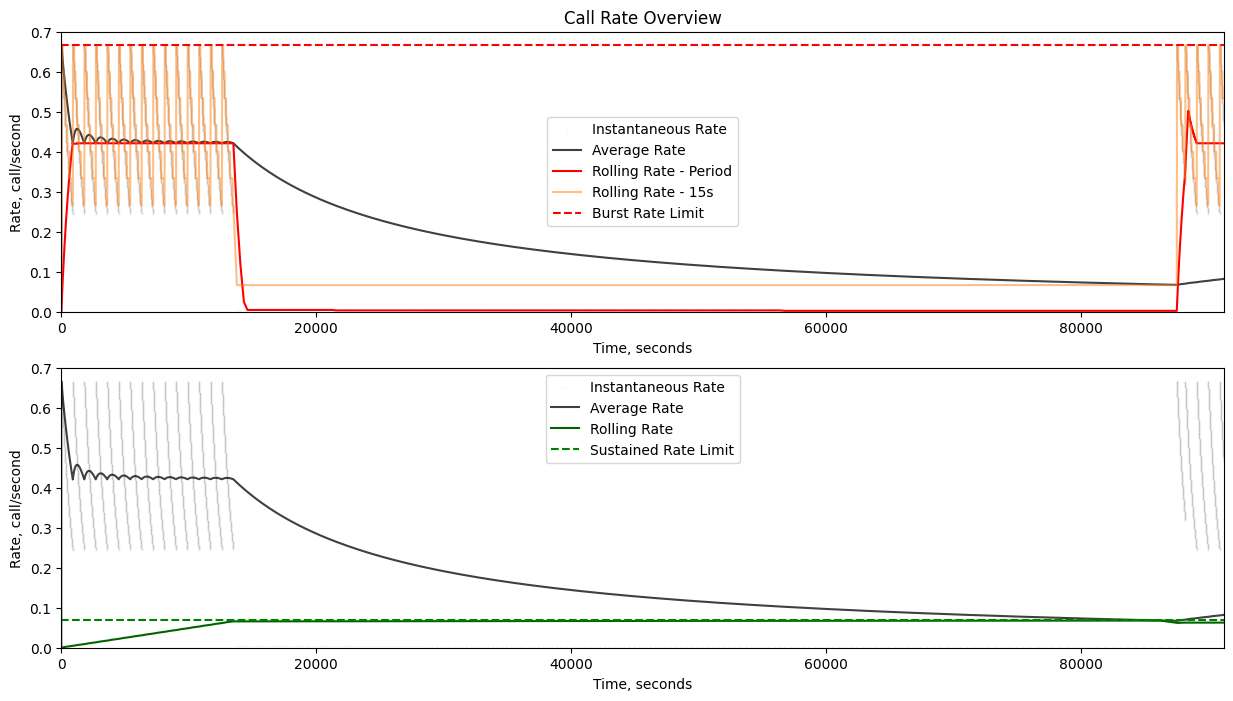

In [22]:
def show_overview(results, burst, sustained):
    fig, ax = plt.subplots(2, 1 ,figsize=(15, 8))
    ax[0].set_title("Call Rate Overview")

    ax[0].scatter(results.time, results.rate, marker='.', s=1, alpha=0.05, color='k', label='Instantaneous Rate')
    ax[0].plot(results.time, results.avg_rate, color='k', alpha=0.75, label='Average Rate')
    ax[0].plot(results.time, results.burst_rate, color='red', label='Rolling Rate - Period')
    ax[0].plot(results.time, results.rate_15, color='C1', alpha=0.5, label='Rolling Rate - 15s')
    # ax[0].plot(results.time, results.rate_30, color='C2', alpha=0.5, label='Rolling Rate - 30s')
    # ax[0].plot(results.time, results.rate_60, color='C3', alpha=0.5, label='Rolling Rate - 60s')
    ax[0].axhline(burst.rate, color='red', alpha=1.0, ls='--', label='Burst Rate Limit')

    ax[0].set_xlim(results.time[0], results.time[-1])
    ax[0].set_ylim(0, None)
    ax[0].set_xlabel("Time, seconds")
    ax[0].set_ylabel("Rate, call/second")
    ax[0].legend()

    ax[1].scatter(results.time, results.rate, marker='.', s=1, alpha=0.05, color='k', label='Instantaneous Rate')
    ax[1].plot(results.time, results.avg_rate, color='k', alpha=0.75, label='Average Rate')
    ax[1].plot(results.time, results.sustained_rate, '-', color='darkgreen', label='Rolling Rate')
    ax[1].axhline(sustained.rate, color='green', alpha=1.0, ls='--', label='Sustained Rate Limit')

    ax[1].legend()
    ax[1].set_xlim(results.time[0], results.time[-1])
    ax[1].set_ylim(0, None)
    ax[1].set_xlabel("Time, seconds")
    ax[1].set_ylabel("Rate, call/second")
    plt.show()

show_overview(results, burst, sustained)

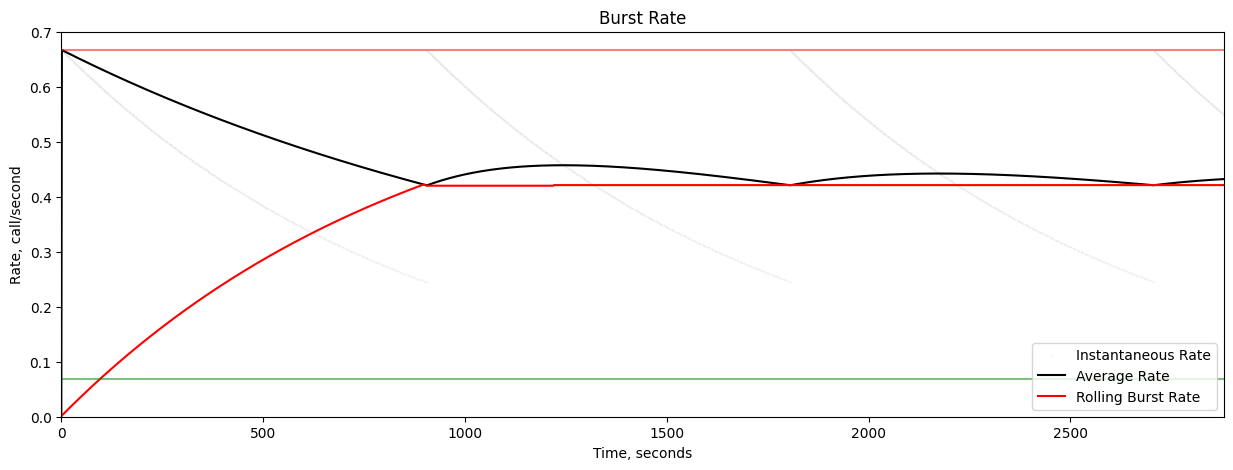

In [4]:
def show_burst_rate(results, burst, sustained):
    plt.figure(figsize=(15, 5))
    plt.title('Burst Rate')

    plt.scatter(results.time, results.rate, marker='.', s=1, alpha=0.05, color='k', label='Instantaneous Rate')
    plt.plot(results.time, results.avg_rate, color='k', label='Average Rate')
    plt.plot(results.time, results.burst_rate, color='red', label='Rolling Burst Rate')

    plt.axhline(burst.rate, color='red', alpha=0.5)
    plt.axhline(sustained.rate, color='green', alpha=0.5)

    plt.legend()
    plt.xlim(0, 3.2*burst.period)
    plt.ylim(0, None)
    plt.xlabel("Time, seconds")
    plt.ylabel("Rate, call/second")
    plt.show()

show_burst_rate(results, burst, sustained)

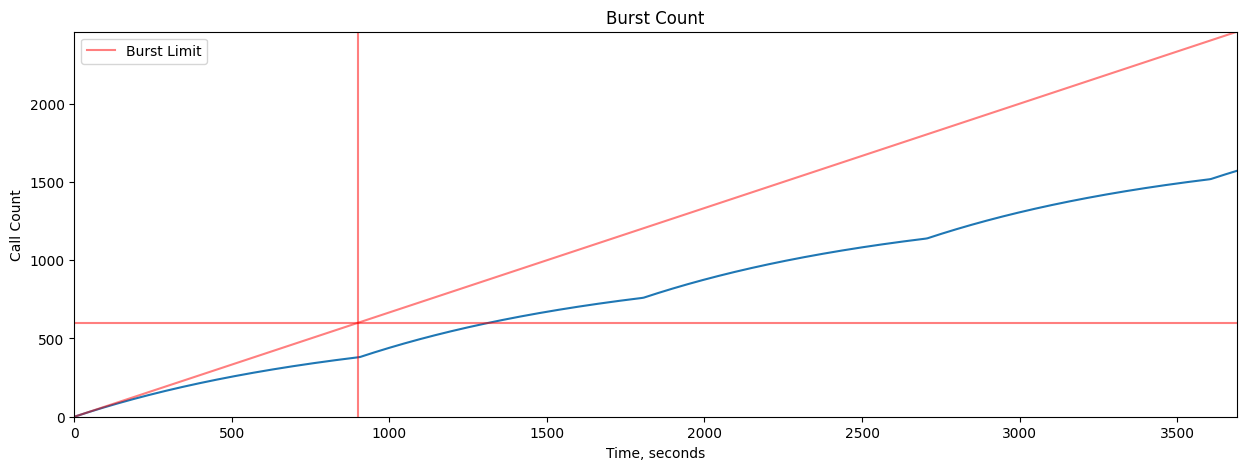

In [5]:
def show_burst_count(results, burst, sustained):
    plt.figure(figsize=(15, 5))
    plt.title('Burst Count')

    plt.plot(results.time, results.count)
    plt.plot(results.time, burst.rate * results.time, color='red', alpha=0.5)
    plt.axhline(burst.count, color='red', alpha=0.5, label='Burst Limit')
    plt.axvline(burst.period, color='red', alpha=0.5)

    plt.legend()
    plt.xlim(0, 4.1*burst.period)
    plt.ylim(0, 4.1*burst.count)
    plt.xlabel("Time, seconds")
    plt.ylabel("Call Count")
    plt.show()

show_burst_count(results, burst, sustained)

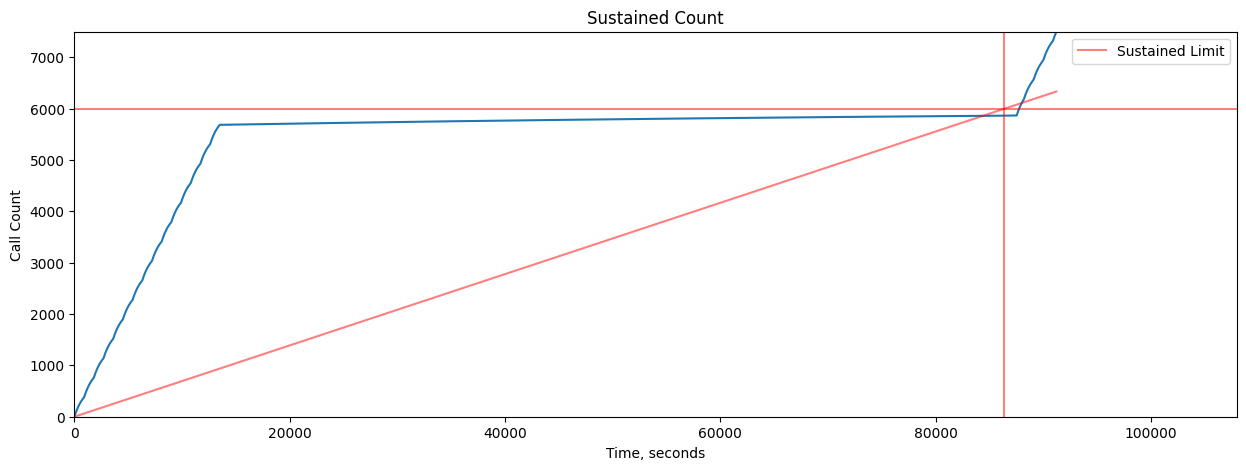

In [6]:
def show_sustained_count(results, burst, sustained):
    plt.figure(figsize=(15, 5))
    plt.title('Sustained Count')

    plt.plot(results.time, results.count)
    plt.plot(results.time, sustained.rate * results.time, color='red', alpha=0.5)
    plt.axhline(sustained.count, color='red', alpha=0.5, label='Sustained Limit')
    plt.axvline(sustained.period, color='red', alpha=0.5)

    plt.legend()
    plt.xlim(0, 1.25*sustained.period)
    plt.ylim(0, 1.25*sustained.count)
    plt.xlabel("Time, seconds")
    plt.ylabel("Call Count")
    plt.show()

show_sustained_count(results, burst, sustained)

# Simulate Real World Case

Add some noise to the time between calls.

In [20]:
throttle_io = ThrottleStateInterface([
    throttle_state_row(id=0, level=0, tat=0, allocation=1),
])

time = TimeWarp()

gcra = GcraMultiRate(rate_io, throttle_io, time=time)

# Set up the mock api endpoint
endpoint = MockEndpoint(time, rate_limits, fixed_period=True)

# setup our mock usage of the endpoint
@gcra.throttle()
def api_request(*args, **kwargs):
    return endpoint.make_request(*args, **kwargs)

# Bombard the endpoint with requests
for _ in range(int(1.25*sustained.count)):
    api_request()

    # Add a reflected normal distribution as the sleep time between calls
    time.sleep(np.random.normal(0, 3)**2)

    # Stop once we get past our long rate limit period
    if time.time() > 1.25*sustained.period:
        break

simulated = Results(endpoint.log, burst, sustained)
burst.usage = 0
sustained.usage = 0

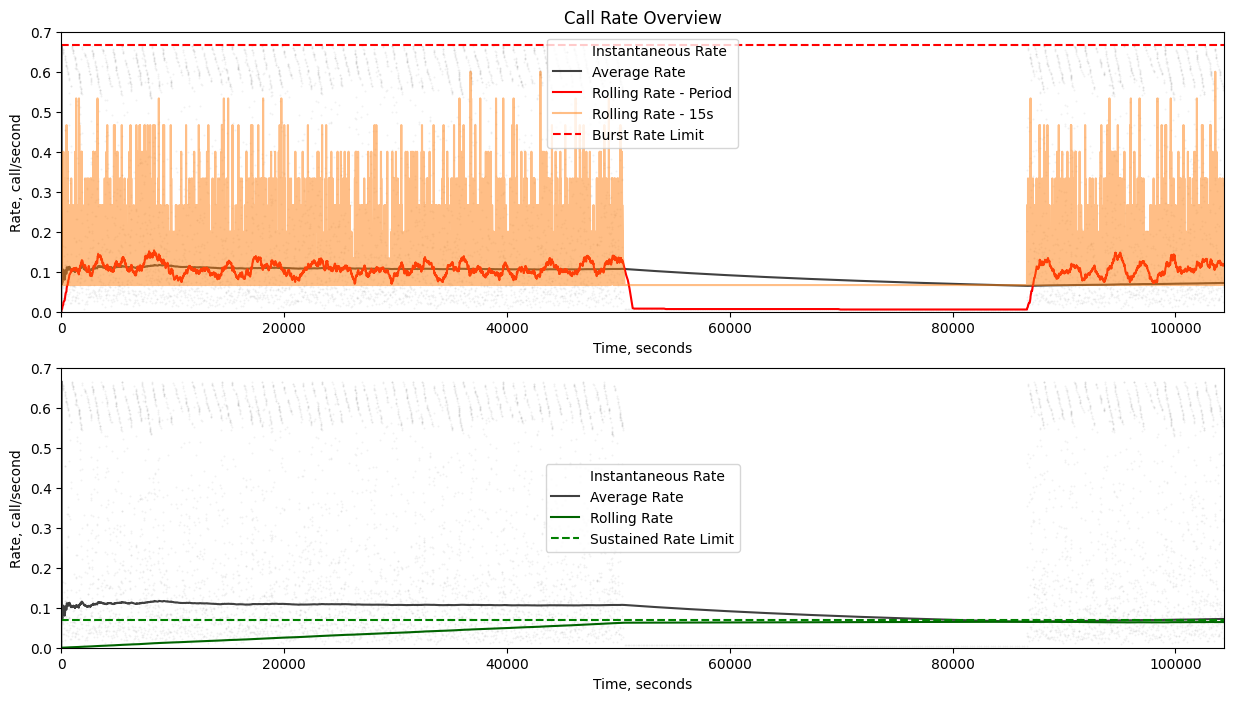

In [23]:
show_overview(simulated, burst, sustained)

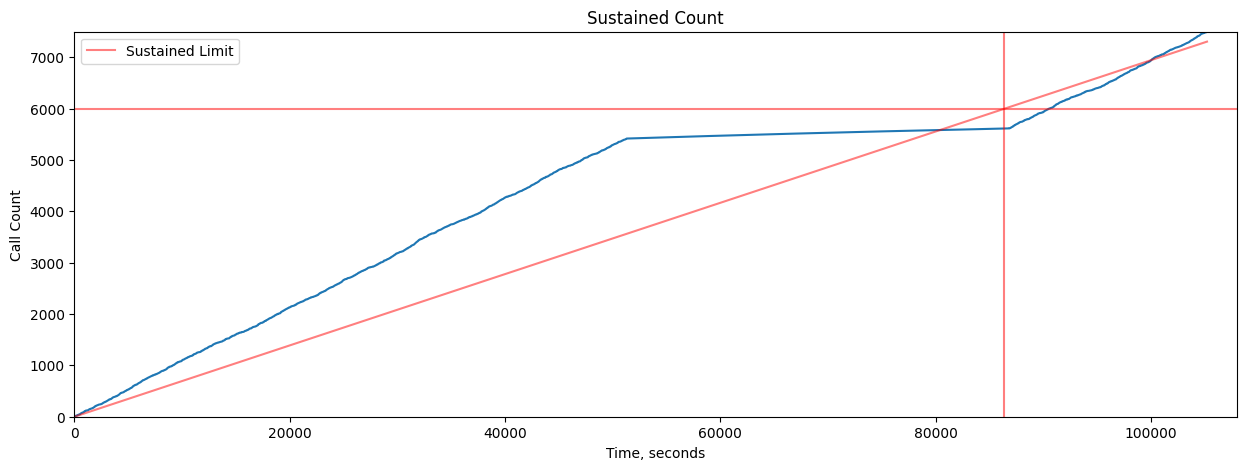

In [10]:
show_sustained_count(simulated, burst, sustained)